In [5]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils, gan, transforms
from cosmikyu import nn as cnn
import os
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random
from itertools import cycle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


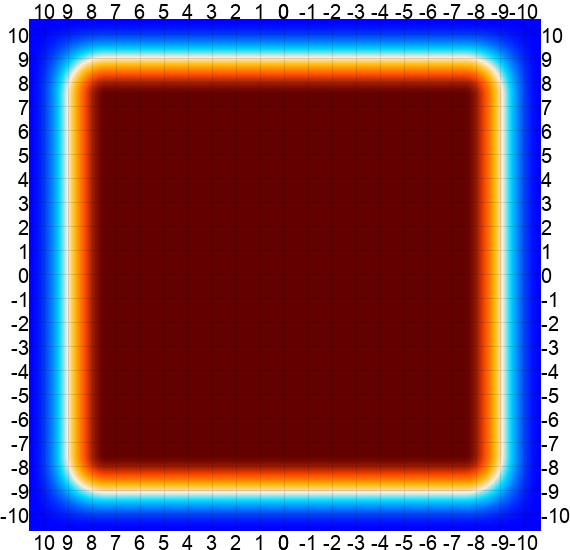

In [6]:
nside = 20
nbatch = nside*nside ## it goes like nbatch**2

shape = (128, 128)
bshape = (128*nside,128*nside)
_, bwcs = omaps.rect_geometry(width_arcmin=64.*nside, px_res_arcmin=0.5)
cuda = False

def get_template(shape, wcs):
    return enmap.zeros(shape, wcs)

def get_mask(taper_percent=15.):
    taper, _ = omaps.get_taper(bshape, bwcs, taper_percent=taper_percent, pad_percent=0.)
    loc = taper == 0
    taper[loc] = np.min(taper[~loc])
    return taper

mask = get_mask()
enplot.pshow(mask, downgrade=5)

In [8]:
bin_edges = np.linspace(0,10000., 50)
lmax=10000
l = np.arange(lmax+1)
beam_fwhm = 0.9
beam_fwhm = np.deg2rad(beam_fwhm/60.)
sigma     = beam_fwhm/(2.*np.sqrt(2.*np.log(2)))
def get_f_ell(l):
    f_ell = np.exp(-(l)**2.*sigma**2./2)
    return l, f_ell
transfer = list(get_f_ell(l))
PITAS = power.PITAS("151020_{}x{}_0.9deconv".format(bshape[0],bshape[1]), mask, mask, bin_edges=bin_edges, lmax=lmax, transfer=transfer)

mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv/curved_full_DLTT_inv.dat
[get_bbl] mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv/curved_full_BBL_DLTT.dat


In [9]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
stat_dir = os.path.join(sehgal_dir, "stats")
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="test141020", transforms=[], dummy_label=False)

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

In [10]:

STAT_TEST = stats.STATS("201020_test_specs_deconv", output_dir=stat_dir, overwrite=False)

def get_data(wcs=bwcs, nside=nside, dataset=SDS_test, taper=True):
    data = SDS_test[0].copy()
    nx, ny = shape
    nshape = (data.shape[0], nx*nside, ny*nside)
    temp = enmap.zeros(nshape, wcs)
    for i in range(nside):
        for j in range(nside):
            cidx = random.randint(0, len(SDS_test)-1)
            sx = i*nx
            sy = j*ny
            temp[:,sy:sy+ny,sx:sx+nx] = SDS_test[cidx][...]
    if taper:
        temp[...] *= get_mask()
    return temp


lmax = 10000
overwrite = True
compts = ["kappa", "ksz", "tsz", "ir", "rad"]
subtasks = np.arange(10, dtype=np.int)
for sim_idx in subtasks:
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    print("processing sim {}".format(sim_idx))
    if STAT_TEST.has_data("dls_radxrad", sim_idx):
        continue
    emap = get_data()

    alms = {}
    for i, compt_idx in enumerate(compts):
        #print(i, compt_idx)
        alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
    del compt_idx

    for compt_idx1, compt_idx2 in product(compts, compts):
        compt_keys = [compt_idx1, compt_idx2]
        compt_keys.sort()
        stat_key = "dls_{}x{}".format(compt_keys[0], compt_keys[1])
        if STAT_TEST.has_data(stat_key, sim_idx):
            continue
        else:
            cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
            l = np.arange(len(cl), dtype=np.float)
            dl = l*(l+1.)/(2*np.pi)*cl
            lbin, dlbin = PITAS.binner.bin(l, dl)
            dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
            STAT_TEST.add_data("lbin", 0, lbin)
            STAT_TEST.add_data(stat_key, sim_idx, dlbin)

    #del alms

_ = STAT_TEST.get_stats(save_data=True)

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_201020_test_specs_deconv.npz
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4
processing sim 5
processing sim 6
processing sim 7
processing sim 8
processing sim 9
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_201020_test_specs_deconv.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_201020_test_specs_deconv.npz
calculating stats


/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:116: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [11]:

STanh = cnn.ScaledTanh(30., 2./30.)

norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
experiment_id = "d6130ff86d194dedbee0f3cba296e250"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_201020/{}/model".format(experiment_id)
print(model_dir)
latent_dim = 256
overwrite =False
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SDUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
STAT_GEN = stats.STATS(experiment_id, output_dir=stat_dir, overwrite=overwrite)
save_points = [0,5,10,15,20]
nsim = 5

for save_point in save_points: 
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", (5,)+shape, latent_dim, cuda=False, nconv_fcgen=64,
                                  nconv_fcdis=64, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, kernal_size=5, stride=2,
                                                            padding=2, output_padding=1, gen_act=STanh)

    DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))
    
    def get_generated(wcs=bwcs, nside=nside, gan=DCGAN_WGP, taper=True):
        shape = gan.shape
        nx, ny = shape[1], shape[2]
        nshape = (shape[0], shape[1]*nside, shape[2]*nside)
        temp = enmap.zeros(nshape, wcs)
        np.random.seed(None)
        generated = gan.generate_samples(nside*nside).data.numpy()
        #ctr = 0
        for i in range(nside):
            for j in range(nside):
                ctr = i*nside+j
                sx = i*nx
                sy = j*ny
                temp[:,sy:sy+ny,sx:sx+nx] = SDUN(generated[ctr])
        if taper:
            temp[...] *= get_mask()
        return temp
    
    subtasks = np.arange(nsim, dtype=np.int)
    for sim_idx in subtasks:
        print("processing sim {}".format(sim_idx))
        emap = get_generated()
        stat_key = "dls_radxrad_r{}".format(save_point)
        if STAT_GEN.has_data(stat_key, sim_idx):
            continue
        alms = {}
        for i, compt_idx in enumerate(compts):
            alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
        del compt_idx
        
        for compt_idx1, compt_idx2 in product(compts, compts):
            compt_keys = [compt_idx1, compt_idx2]
            compt_keys.sort()
            stat_key = "dls_{}x{}_r{}".format(compt_keys[0], compt_keys[1],save_point)
            if STAT_GEN.has_data(stat_key, sim_idx):
                continue
            else:
                cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
                l = np.arange(len(cl), dtype=np.float)
                dl = l*(l+1.)/(2*np.pi)*cl
                lbin, dlbin = PITAS.binner.bin(l, dl)
                dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
                STAT_GEN.add_data("lbin", 0, lbin)
                STAT_GEN.add_data(stat_key, sim_idx, dlbin)

        #del alms
_ = STAT_GEN.get_stats(save_data=True)

Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_201020/d6130ff86d194dedbee0f3cba296e250/model
[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_d6130ff86d194dedbee0f3cba296e250.npz
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _0
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _5
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _10
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _15
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _20
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_d6130ff86d194dedbee0f3cba296e250.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_d6130ff86d194dedbee0f3cba296e250.npz
calculating stats


/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:116: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [6]:
STAT_GEN_CORR = stats.STATS("sehgal_cosmoganwgpv6_gen_corr", output_dir=stat_dir, overwrite=True)
for st_key in STAT_GEN.storage:
    if st_key == "lbin": 
        STAT_GEN_CORR.add_data("lbin", 0, STAT_GEN.storage["lbin"][0])
        continue
    ost_key = "_".join(st_key.split("_")[:2])
    nst_key = st_key 
    transf = STAT_TEST.stats[ost_key]["mean"]/STAT_GEN.stats[st_key]["mean"]
    for sim_idx in STAT_GEN.storage[st_key]:
        STAT_GEN_CORR.add_data(nst_key, sim_idx, STAT_GEN.storage[st_key][sim_idx]*transf)
        
STAT_GEN_CORR.get_stats(save_data=False)

        

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
calculating stats


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'lbin': {'mean': array([ 103. ,  306.5,  510.5,  714.5,  918.5, 1122.5, 1326.5, 1530.5,
         1734.5, 1938.5, 2142.5, 2346.5, 2551. , 2755.5, 2959.5, 3163.5,
         3367.5, 3571.5, 3775.5, 3979.5, 4183.5, 4387.5, 4591.5, 4795.5,
         5000. , 5204.5, 5408.5, 5612.5, 5816.5, 6020.5, 6224.5, 6428.5,
         6632.5, 6836.5, 7040.5, 7244.5, 7449. , 7653.5, 7857.5, 8061.5,
         8265.5, 8469.5, 8673.5, 8877.5, 9081.5, 9285.5, 9489.5, 9693.5,
         9898. ]),
  'cov': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'corrcoef': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

<Figure size 432x288 with 0 Axes>

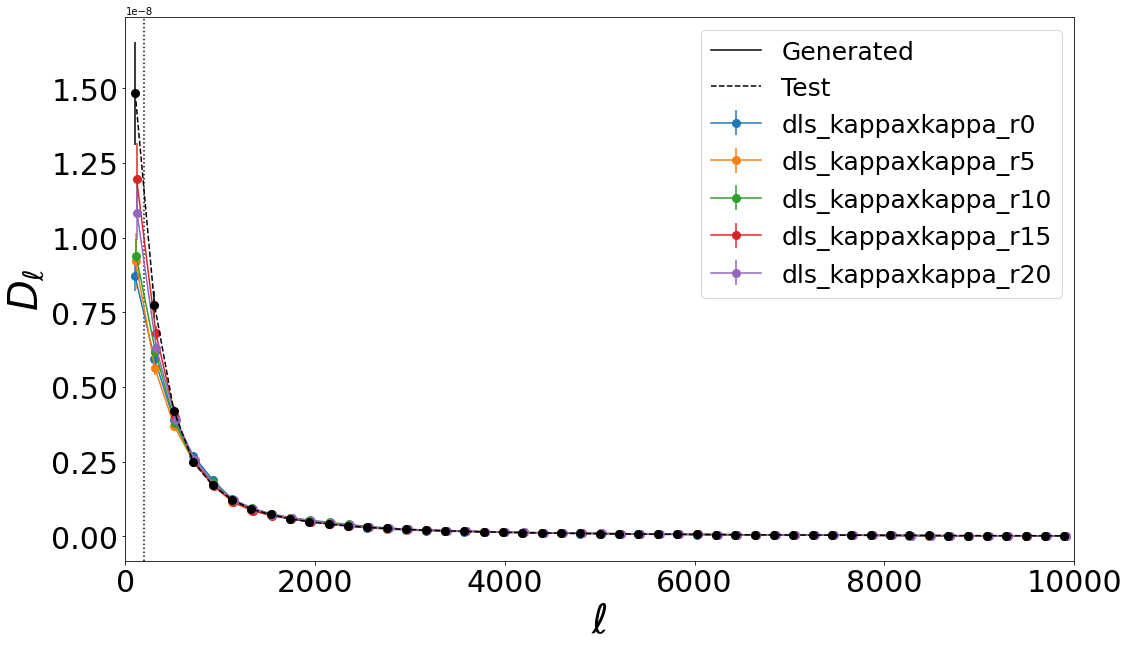

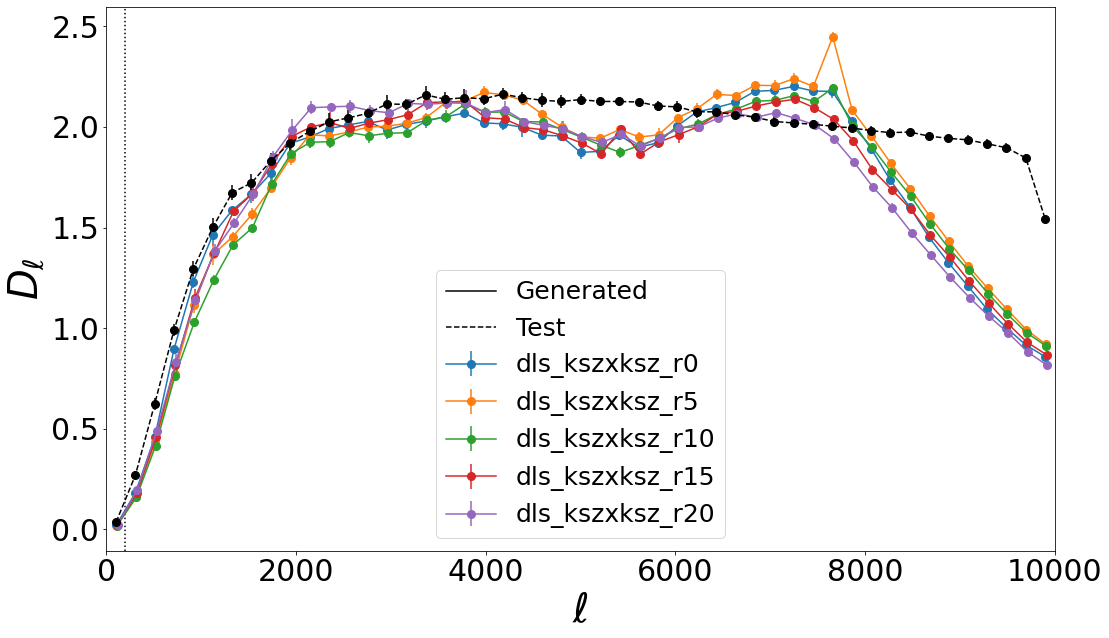

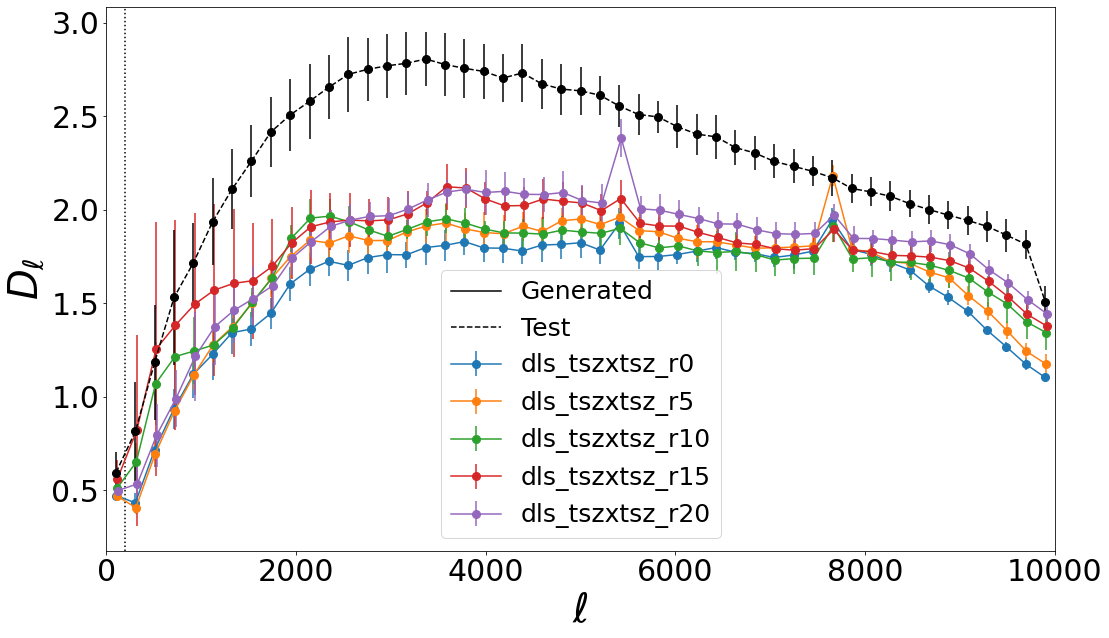

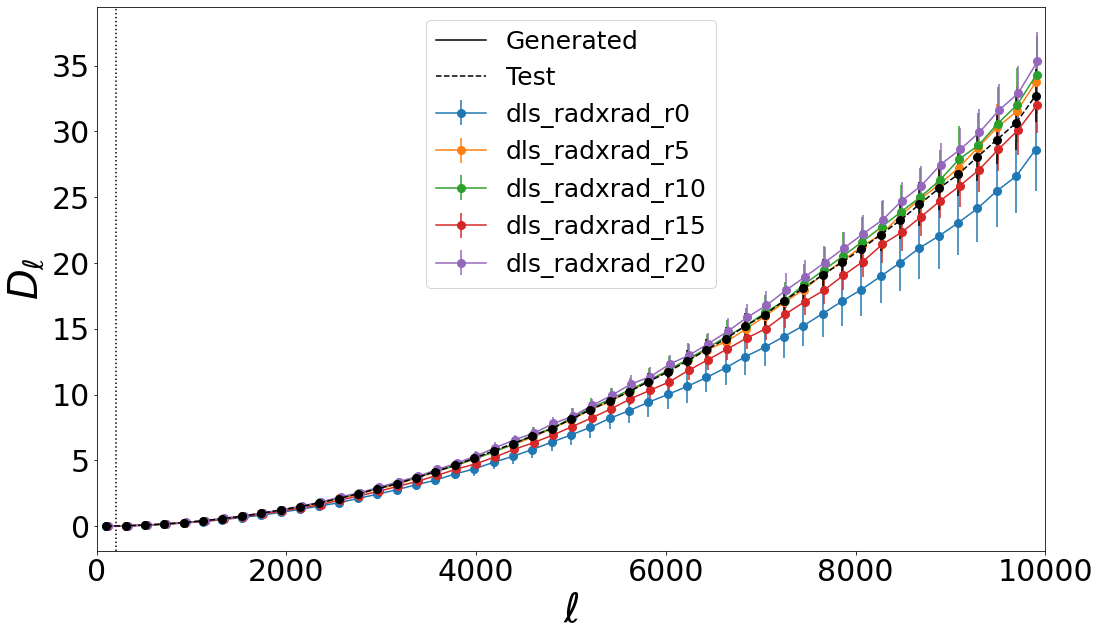

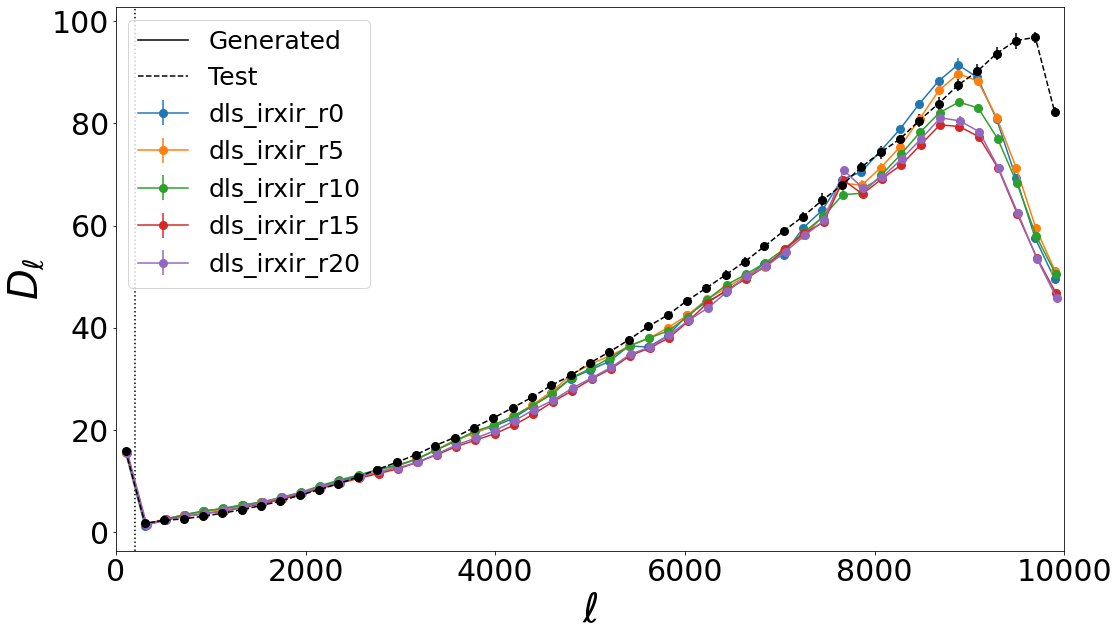

In [13]:
plt.clf()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
   
    mult_fact = 1.1**2 if key1 == "tsza" else 1
    for save_point in save_points[:]:#,20]:
        skey = key + "_r" + str(save_point)
        lbin = STAT_GEN.storage["lbin"][0].copy() 
        dlbin = STAT_GEN.stats[skey]["mean"].copy()*mult_fact
        std = STAT_GEN.stats[skey]["std"].copy()
        if key1 == "kappa":
            dlbin /= lbin**2
            std /= lbin**2
       
        plt.errorbar(lbin+save_point, dlbin, std,  marker="o",markersize=8, label=skey)
    

    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    if key1 == "kappa":
        dlbin /= lbin**2
        std /= lbin**2
    plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=200, ls=":", color="k")
    plt.xlim(0,10000)
    #plt.yscale("log")
    plt.show()

NameError: name 'STAT_GEN_CORR' is not defined

<Figure size 432x288 with 0 Axes>

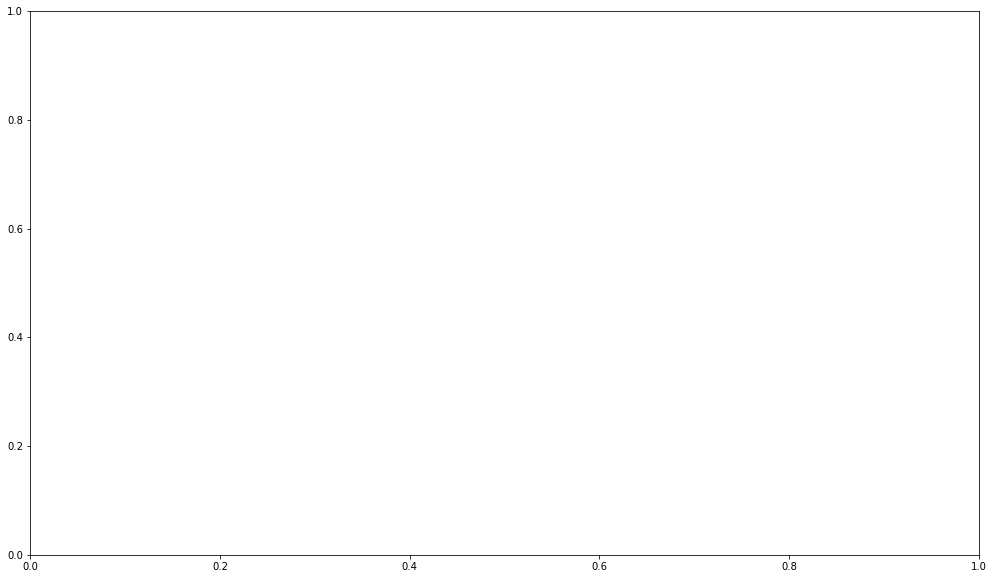

In [59]:

plt.clf()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key + "_r" + str(save_points[0])

    dlbin_gen = STAT_GEN_CORR.stats[skey]["mean"].copy()
    std_gen = STAT_GEN_CORR.stats[skey]["std"].copy()
    
    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    #plt.plot(lbin,(dlbin/dlbin_gen), marker="*")
    #plt.plot(lbin, std_gen/std*(dlbin/dlbin_gen), marker="o")
    plt.plot(lbin, std_gen, marker="x")
    plt.plot(lbin, std, marker="o")
    #plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    #plt.plot([],[], label=key, color=color)
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=200, ls=":", color="k")
    plt.xlim(0,10000)
    #plt.yscale("log")
    plt.show()

In [15]:
def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":" CIB ",
               "rad":"Radio",
              }
    return storage[key]

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

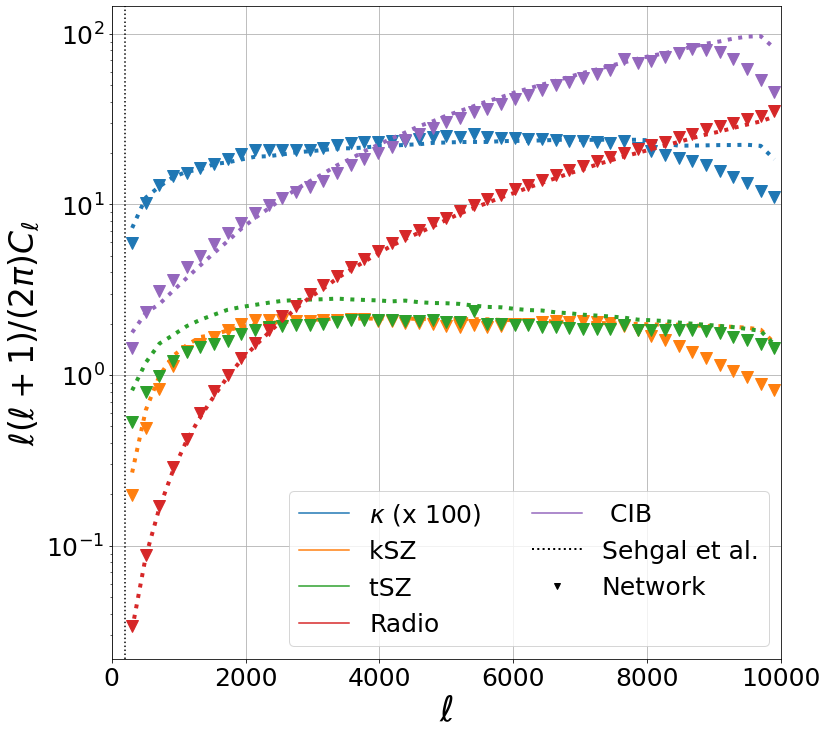

In [16]:
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()


loc = np.where(lbin>200)
for key1 in compts:
    #if key1 == "kappa": continue
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key+"_r{}".format(save_points[-1])
    multi_fact = 1e4 if key1 == "kappa" else 1
    corr_fact  = 1.1**2 if key1 == "tsza" else 1 
    #multi_fact = 1.2**2 if key1 == "tsz" else 1
 
    color = next(ax._get_lines.prop_cycler)['color']
    
    lbin = STAT_TEST.storage["lbin"][0]
    dlbin = STAT_TEST.stats[key]["mean"]*multi_fact
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=4, marker="",markersize=8, color=color, ls=":")
    lbin = STAT_GEN.storage["lbin"][0]
    dlbin = STAT_GEN.stats[skey]["mean"]*multi_fact*corr_fact
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=2, marker="v",markersize=12, color=color, ls="")
    

    plt.plot([],[], label=key2label(key1), color=color)
plt.plot([],[], lw=2, marker="", label="Sehgal et al.", color="k", ls=":")
plt.plot([],[], lw=2, marker="v", ls="", label="Network", color="k")
ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
ax.set_xlabel(r"$\ell$", fontsize=35)
plt.legend(fontsize=25, ncol=2)



ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.axvline(x=200, ls=":", color="k")
ax.set_yscale("log")
ax.grid()
plt.xlim(0, 10000)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(plot_path("151020_ps_before_transfer.pdf"), bbox_inches='tight')
plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


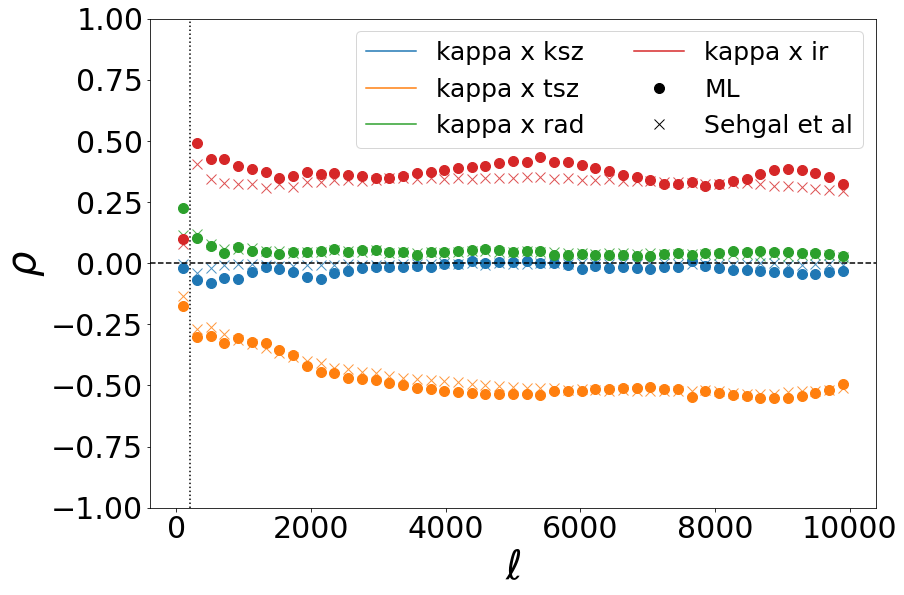

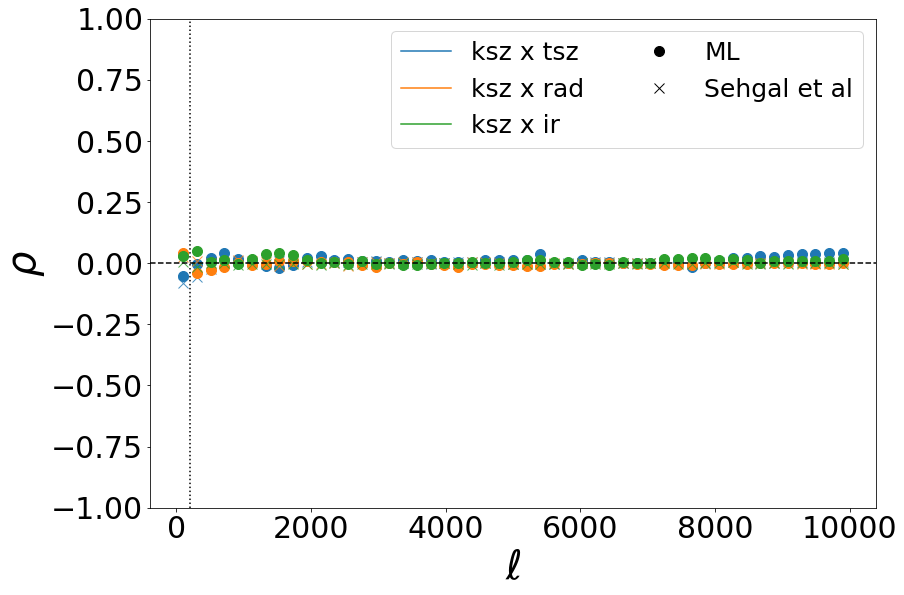

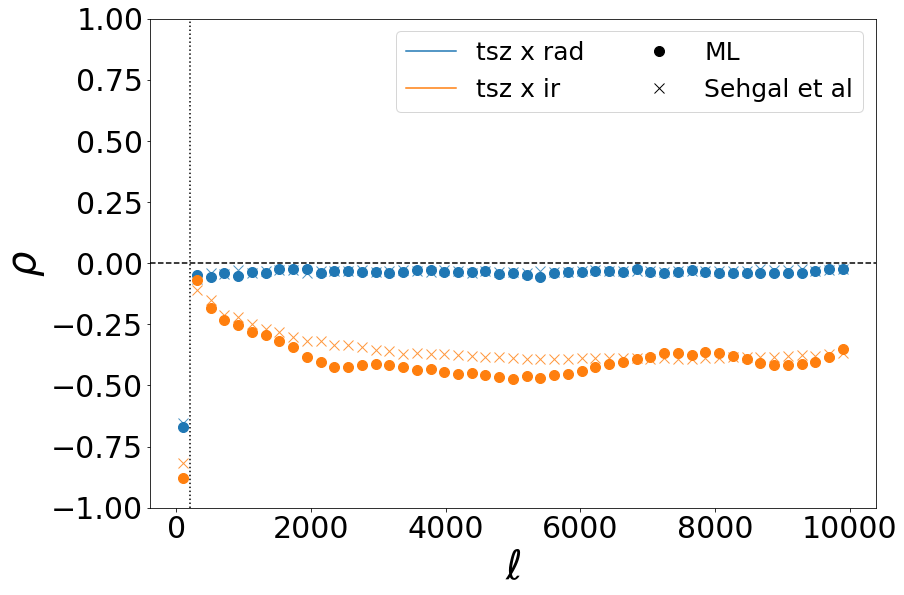

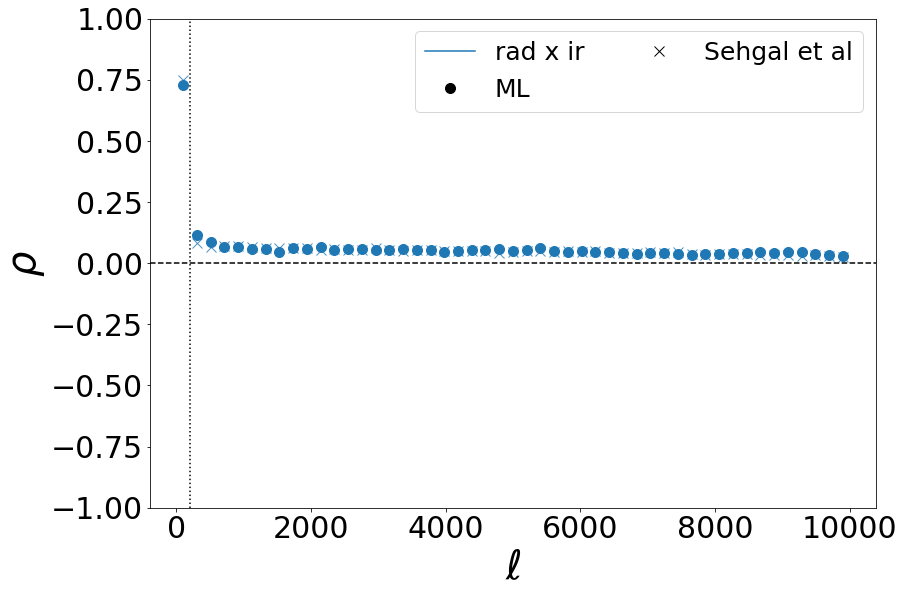

In [17]:

def get_correlation(STAT, key1, key2, postfix=""):
    key1 = compts[i]
    key2 = compts[j]
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)+postfix
    
    dls_x = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key1, key1])+postfix
    dls_1 = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key2, key2])+postfix
    dls_2 = STAT.stats[key]["mean"].copy()

    return dls_x/np.sqrt(dls_1*dls_2)
    

compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for i in range(5-1):
    fig = plt.figure(figsize=(13,9))
    ax = fig.gca()
    for j in range(i+1,5):
        key1, key2 = compts[i], compts[j]
        lbin = STAT_GEN.storage["lbin"][0]
        color = next(ax._get_lines.prop_cycler)['color']
        rho = get_correlation(STAT_TEST, key1, key2)
        plt.plot(lbin, rho, alpha=0.8,  ls="", marker="x", markersize=10, color=color)

        rho = get_correlation(STAT_GEN, key1, key2, "_r{}".format(save_points[-1]))
        plt.plot(lbin, rho, alpha=1,  ls="", marker="o", markersize=10, color=color)
        plt.plot([],[], label="{}".format(" x ".join([key1, key2])), color=color)
    plt.plot([],[], ls="",label="ML", color="k",  marker="o", markersize=10)
    plt.plot([],[], ls="",label="Sehgal et al", color="k",  marker="x", markersize=10)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$\rho$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.ylim(-1,1)
    plt.axvline(x=200, ls=":", color="k")
    plt.axhline(y=0, ls="--", color="k")
    plt.legend(fontsize=25, loc="upper right", ncol=2)
    plt.show()
        
